In [80]:
import sys

sys.path.append("..")

import time
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from utils import config

In [81]:
#Load data from the dataset
indicators = config.INDICATORS
target = config.TARGET
separator = "','"
sql_string = f""" SELECT
                t2.Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(indicators)}');"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_string,conn)

In [82]:
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == target].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

# No tinc clar si volem pujar country i year com a columnes o millor com a índexs
# df = df.reset_index(level=["Country","Year"])
df

Foreign direct investment, net inflows (% of GDP)  \
Country     Year                                                      
Afghanistan 1960                                                NaN   
            1961                                                NaN   
            1962                                                NaN   
            1963                                                NaN   
            1964                                                NaN   
...                                                             ...   
Zimbabwe    2006                                           0.734768   
            2007                                           1.301978   
            2008                                           1.168557   
            2009                                           1.287226   
            2010                                           1.760743   

                  Foreign direct investment, net outflows (% of GDP)  \
Country     Year                                                       
Afghanistan 1960                                                NaN    
            1961                                                NaN    
            1962                                                NaN    
            1963                                                NaN    
            1964                                                NaN    
...                                                             ...    
Zimbabwe    2006                                                NaN    
            2007                                                NaN    
            2008                                                NaN    
            2009                                                NaN    
            2010                                                NaN    

                  GDP growth (annual %)  GDP per capita growth (annual %)  \
Country     Year                                                            
Afghanistan 1960                    NaN                               NaN   
            1961                    NaN                               NaN   
            1962                    NaN                               NaN   
            1963                    NaN                               NaN   
            1964                    NaN                               NaN   
...                                 ...                               ...   
Zimbabwe    2006              -3.461495                         -4.516923   
            2007              -3.653327                         -4.883986   
            2008             -17.668947                        -18.874825   
            2009               5.984391                          4.242302   
            2010              11.375921                          9.360237   

                  GNI growth (annual %)  \
Country     Year                          
Afghanistan 1960                    NaN   
            1961                    NaN   
            1962                    NaN   
            1963                    NaN   
            1964                    NaN   
...                                 ...   
Zimbabwe    2006              -4.303630   
            2007              -4.744956   
            2008             -19.799236   
            2009              12.438273   
            2010               8.345923   

                  General government final consumption expenditure (% of GDP)  \
Country     Year                                                                
Afghanistan 1960                                                NaN             
            1961                                                NaN             
            1962                                                NaN             
            1963                                                NaN             
            1964                                                NaN             
...                         

In [ ]:
# Rows where our target is not missing
df = df[df[target].notna()]
df = df.dropna(axis='columns',thresh=6000)
df = df.dropna()
# df

In [77]:
features = df.columns.tolist()
#features.remove("Year")
#features.remove("Country")
features

['Foreign direct investment, net inflows (% of GDP)',
 'Foreign direct investment, net outflows (% of GDP)',
 'GDP growth (annual %)',
 'GDP per capita growth (annual %)',
 'GNI growth (annual %)',
 'General government final consumption expenditure (% of GDP)',
 'Inflation, GDP deflator (annual %)',
 'Population ages 0-14 (% of total)',
 'Population ages 15-64 (% of total)',
 'Population ages 65 and above (% of total)',
 'Population density (people per sq. km of land area)',
 'Population growth (annual %)',
 'Population in largest city',
 'Population in the largest city (% of urban population)',
 'Population in urban agglomerations of more than 1 million',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Rural population',
 'Rural population (% of total population)',
 'Rural population growth (annual %)',
 'Urban population',
 'Urban population (% of total)',
 'Urban population growth (annual %)',
 'Next GDP Growth']

In [27]:
country_list = df.Country.unique() #Array with all column names

country_example = "United Kingdom"

country_df = df.loc[df["Country"] == country_example]

Choose one cell from the following:

In [19]:
# 1.1) Data treatment for one country, 1 previous year
dataset = country_df
year_list = (dataset["Year"].values.tolist())
n_years = 1

y = dataset[target].values.tolist()
X = dataset[features].to_numpy()

# Hem de modificar els arrays per tal de tenir les dades del gpd de l'any seguent
del y[0]

#Last item on X to do the predict
predict_data = X[-1] 
print(f"Y_predict data Shape: {predict_data.shape}")
X = np.delete(X,-1,0)

Y_predict data Shape: (17,)


In [37]:
# 1.2) Data treatment for one country, 2 previous years
dataset = country_df
year_list = (dataset["Year"].values.tolist())
n_years = 2

# Hem de modificar els arrays per tal de tenir les dades del gpd de l'any seguent
y = dataset[target].values.tolist()
del y[:2]

X_one = dataset[features].to_numpy()
X_two = X_one
X_one = np.delete(X_one,[0,-1],0)
X_two = np.delete(X_two,[-1,-2],0)
X = np.concatenate((X_one,X_two), axis=1)

In [24]:
# 2.1) Data treatment for all countries, 1 previous year
dataset = df
year_list = (dataset["Year"].values.tolist())
n_years = 1

X = np.array([]) #Indicators (Train)
y = np.array([]) #GDP per capita growth (Test)
# predict_data = []

for country in country_list:
    country_df = df.loc[df["Country"] == country]
    X_temp = country_df[features].to_numpy()
    y_temp = country_df[target].values.tolist()
    X_temp = np.delete(X_temp,-1,0)
    del y_temp[0]
    X = np.append(X,X_temp)
    y = np.append(y,y_temp)

In [39]:
# 2.2) Data treatment for all countries, 2 previous years
dataset = df
year_list = (dataset["Year"].values.tolist())
n_years = 2

X = np.array([]) #Indicators (Train)
y = np.array([]) #GDP per capita growth (Test)
# predict_data = []

def append_country(df,country,X,y):
    country_df = df.loc[df["Country"] == country]
    X_one = country_df[features].to_numpy()
    X_two = X_one
    X_one = np.delete(X_one,[0,-1],0)
    X_two = np.delete(X_two,[-1,-2],0)
    X_temp = np.concatenate((X_one,X_two), axis=1)
    y_temp = country_df[target].values.tolist()
    del y_temp[:2]
    X = np.append(X,X_temp)
    y = np.append(y,y_temp)

for country in country_list:
    try:
        append_country(df,country,X,y)
    except IndexError:
        print(f"{country} doesn't have enough data")

Cayman Islands doesn't have enough data


In [5]:
# 2.3) Data treatment for all countries, n_years previous years
dataset = df
year_list = (dataset["Year"].values.tolist())
n_years = 3

X = np.array([]) #Indicators (Train)
y = np.array([]) #GDP per capita growth (Test)
# predict_data = []

def append_country_n(df,country,X,y,n_years):
    country_df = df.loc[df["Country"] == country]
    X_one = country_df[features].to_numpy()
    X_array = []
    for year in range(n_years):
        list_to_delete = [*range(-1-year,0)]+[*range(n_years-year-1)]
        X_array.append(np.delete(X_one,list_to_delete,0))
    X_temp = np.concatenate([Xi for Xi in X_array], axis=1)
    y_temp = country_df[target].values.tolist()
    del y_temp[:n_years]
    X = np.append(X,X_temp)
    y = np.append(y,y_temp)
    return X,y

for country in country_list:
    try:
        X,y = append_country_n(df,country,X,y,n_years)
    except IndexError:
        print(f"{country} doesn't have enough data")

Angola doesn't have enough data
Côte d'Ivoire doesn't have enough data
Haiti doesn't have enough data


In [20]:
#Arrays lenght
print("Dp lenght (Year list) = ",len(dataset))

#To plot the data we need to convert the data in to pandas
y_pandas = pd.Series(y)
X_pandas = pd.DataFrame(X.reshape(len(y),len(features)*n_years))
print(f"X shape: {X_pandas.shape}")
print(f"y shape: {y_pandas.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_pandas, y_pandas, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Dp lenght (Year list) =  41
X shape: (40, 17)
y shape: (40,)
X_train shape: (28, 17)
X_test shape: (12, 17)
y_train shape: (28,)
y_test shape: (12,)


In [21]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)

results_df = pd.DataFrame(X_test).copy() # Copy, otherwise results_df and X_test refer to the same object!
year_list = pd.Series(year_list)
results_df["year"] = year_list
results_df = results_df.sort_values("year")
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")
# results_df

RMSE: 3.851037673475578
R^2: -1.708875380947208


In [22]:
#Gradient Boosting
gbm_hyperparams = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'loss': 'ls',
    'random_state' : 1,
}
gbm_model = GradientBoostingRegressor(**gbm_hyperparams)

t0 = time.time()
gbm_model.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
gbm_y_pred = gbm_model.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = pd.DataFrame(X_test).copy()
year_list = pd.Series(year_list)
results_df["year"] = year_list
results_df = results_df.sort_values("year")
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

# results_df

Elapsed time training: 0.06924939155578613 seconds
Elapsed time predicting: 0.001856088638305664 seconds
RMSE: 2.5283680451885435
R^2: -0.16765374752743734


In [28]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential([
    keras.Input(shape=(len(features)*n_years)),
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(1, activation='softmax'),
])

#Training, adam optimizer
model.compile(optimizer="adam",
             loss="mean_squared_error",
             )

In [27]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 2/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 3/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 4/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 5/50
57/57 [==============================] - 0s 998us/step - loss: 29.3442
Epoch 6/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 7/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 8/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 9/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 10/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 11/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 12/50
57/57 [==============================] - 0s 1ms/step - loss: 29.3442
Epoch 13/50
57/57 [================

A partir d'aquí no he tocat res, només he afegit "feature_names=features" als plots de shap

In [46]:
predict_data = predict_data.reshape(1,-1) #Respahe to predict
linear_y_pred = linear_model.predict(predict_data)
year_pred = (year_list[len(year_list)-1]+1)
print("GDP Growth Prediction: ",year_pred,linear_y_pred)

GDP Growth Prediction:  2011 [1.5873338]


NameError: name 'results_df' is not defined

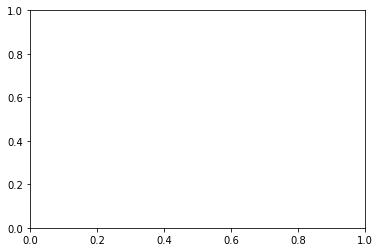

In [12]:
#Predicted Value Plot

fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.scatter(results_df["y_real"], results_df["y_pred"], s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

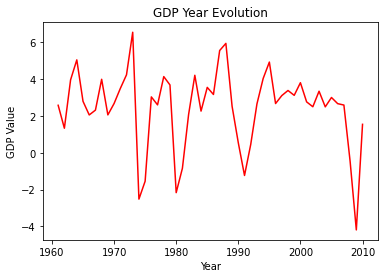

In [14]:
#Filer data by countries using panda
country_list = df.Country.unique()
country = df.loc[df["Country"] == "United Kingdom"]
country.head()

# Time evolution GDP growth of One Country
year = country["Year"]
gdp = country["GDP growth (annual %)"]

fig, ax = plt.subplots()
ax.set_title("GDP Year Evolution")
ax.set_ylabel("GDP Value")
ax.set_xlabel("Year")
ax.plot(year, gdp, c="red")
plt.show()


In [26]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(gbm_model)

In [27]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 1.67 s, sys: 4.06 ms, total: 1.68 s
Wall time: 1.67 s


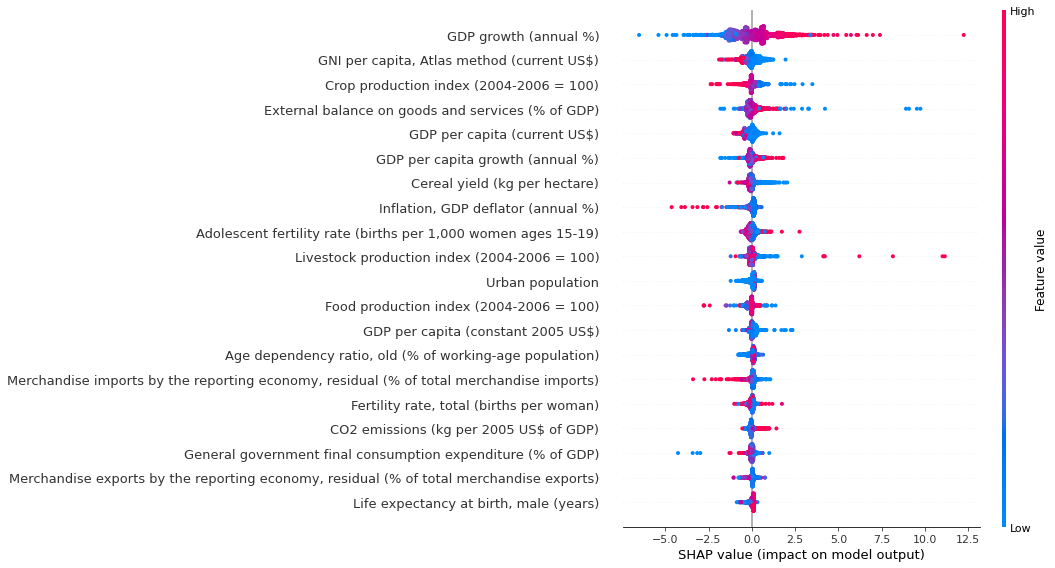

In [39]:
shap.summary_plot(shap_values, X_test,feature_names=features)

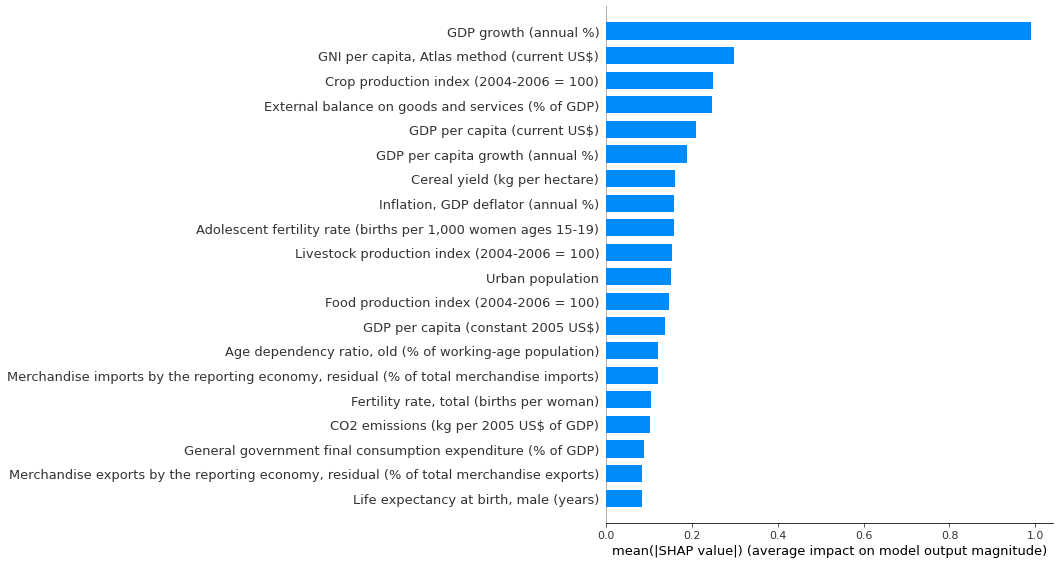

In [38]:
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=features)